## Taking zips and extracting the data to the extracted folder

In [2]:
import zipfile
import os

for file in os.listdir('met_eireann_data/zips'):
    if file.endswith('.zip'):
        path_to_zip_file = os.path.join('met_eireann_data/zips', file)
        directory_to_extract_to = os.path.join('met_eireann_data/extracted', file[:-4])  # Remove .zip extension
        if not os.path.exists(directory_to_extract_to):
            os.makedirs(directory_to_extract_to)
        
            with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
                zip_ref.extractall(directory_to_extract_to)

## Pipeline to clean data from raw format to each row including the station name and all of available weather data

In [33]:
import pandas as pd
dfs = []
for folder in os.listdir('met_eireann_data/extracted'):
    if os.path.isdir(os.path.join('met_eireann_data/extracted', folder)):
        for file in os.listdir(os.path.join('met_eireann_data/extracted', folder)):
            if file.endswith('.csv'):
                if file != 'hly1575.csv':
                    continue
                skiprows = 0
                with open(f'met_eireann_data/extracted/{folder}/{file}', 'r') as f:
                    for line in f:
                        if line.startswith('Station Name'):
                            station_name = line.split(':')[1].strip()
                        elif line.startswith('Latitude'):
                            Latitude = line.split(',')[0].strip()
                            Longitude = line.split(',')[1].strip()
                        elif line.startswith('Station Height'):
                            Station_Height = line.split(':')[1].strip()
                        elif line.split(',')[0] == 'date':
                            break
                        elif line.split(',')[0] == 'date':
                            break
                        skiprows += 1
                print(skiprows)
                df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)
                dfs.append((df, station_name, Latitude, Longitude, Station_Height, file))

                # with open(f'met_eireann_data/extracted/{folder}/{file[:-4]}.txt', 'w') as f:
                #     with open(f'met_eireann_data/extracted/{folder}/{file}', 'r') as f2:
                #         for line in f2:
                            
                print(file, station_name, Latitude, Longitude, Station_Height, df.shape)

23


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_4705/3000491759.py:25: DtypeWarning: Columns (2,6,7,8,9,12,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'met_eireann_data/extracted/{folder}/{file}', skiprows=skiprows)


hly1575.csv MALIN HEAD Latitude:55.372 Longitude: -7.339 20 M (616584, 21)


In [34]:
# Process date column to datetime object and filter to only include data from 2014 onwards
# Add station name at the start and save station metadata in a separate csv file.
# Convert rain, temp, wetb, dewpt, vappr, rhum, msl, wdsp, wddir, sun, vis, clht, clamt to float values if they are columns in the dataframe
# If there are any non float values in these columns (e.g ' ' or '---') convert them to NaN
# Save cleaned data to new csv files in a new folder titled cleaned and file name as station_name.csv


from datetime import datetime


for df_list in dfs:
    df, station_name, Latitude, Longitude, Station_Height, file = df_list

    # Process date column to datetime object
    df['date'] = pd.to_datetime(df['date'], format='mixed')
    df = df[df['date'] >= datetime(2014, 1, 1)]

    # clean columns and convert to numeric values 
    columns_to_convert = ['rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'wdsp', 'wddir', 'sun', 'vis', 'clht', 'clamt']
    for col in columns_to_convert:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if not os.path.exists('met_eireann_data/cleaned'):
        os.makedirs('met_eireann_data/cleaned')
    
    # write additional metadata to a separate txt file with the same name as the csv file
    with open(f'met_eireann_data/cleaned/{station_name}_metadata.txt', 'w') as f:
        f.write(f'Station Name: {station_name}\n')
        f.write(f'Latitude: {Latitude}\n')
        f.write(f'Longitude: {Longitude}\n')
        f.write(f'Station Height: {Station_Height}\n')

    df.to_csv(f'met_eireann_data/cleaned/{station_name}.csv', index=False)


/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_4705/528062988.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


## Evaluating and visualising the fields availbe for each station

In [41]:
import os
import pandas as pd

def load_all_stations_cleaned_data():
    dfs = []
    for file in os.listdir('met_eireann_data/cleaned'):
        if file[-4:] == '.csv':
            df = pd.read_csv(f'met_eireann_data/cleaned/{file}')
            dfs.append((df, file))
    return dfs

In [42]:
import os
import pandas as pd

stations = {}
columns = set()

dfs = load_all_stations_cleaned_data()

for df_tuple in dfs:
    df, file_name = df_tuple

    print(file_name, df.shape)

    stations[file_name[:-4]] = df.columns.tolist()
    for col in df.columns:
        columns.add(col)
columns_present_df = pd.DataFrame(columns=['Station'] + list(columns) + ['num_cols'], index=None)
for station, cols in stations.items():
    col_present = []
    num_cols = 0
    for col in columns:
        if col in cols:
            col_present.append(1)
            num_cols += 1
        else:
            col_present.append(0)
    col_present.append(num_cols)
    columns_present_df.loc[len(columns_present_df)] = [station] + col_present

columns_present_df.set_index('Station', inplace=True)

# sort the rows by the number of columns present in descending order
columns_present_df = columns_present_df.sort_values(by='num_cols', ascending=False)
columns_present_df = columns_present_df.drop(columns=['num_cols'])


FINNER.csv (102265, 15)
SHERKIN ISLAND.csv (102265, 15)
JOHNSTOWN CASTLE 2.csv (102265, 15)
VALENTIA OBSERVATORY.csv (102265, 21)
ATHENRY.csv (102265, 15)
NEWPORT.csv (102265, 15)
PHOENIX PARK.csv (102265, 11)
GURTEEN.csv (102265, 15)
MACE HEAD.csv (102265, 15)
SHANNON AIRPORT.csv (102265, 21)
MALIN HEAD.csv (102265, 21)
MULLINGAR.csv (102265, 15)
ROCHES POINT.csv (102265, 15)
MARKREE.csv (102265, 11)


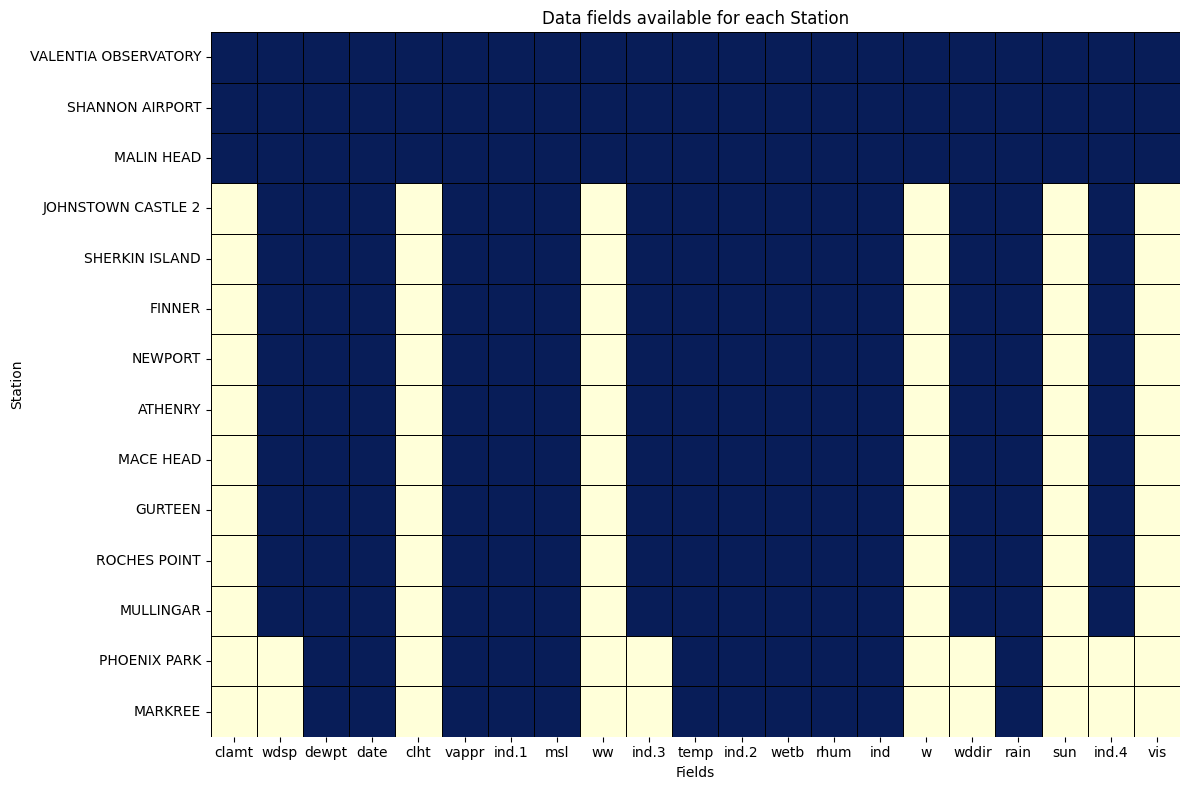

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(columns_present_df, cmap='YlGnBu', cbar=False, linewidths=0.5, linecolor='black')
plt.title('Data fields available for each Station')
plt.xlabel('Fields')
plt.ylabel('Station')
plt.tight_layout()
plt.show()

## Process all of the station data to one common csv to make it simpler to load in 

In [ ]:
dfs = load_all_stations_cleaned_data()

max_cols = 0
max_cols_columns = []
for df_tuple in dfs:
    df, file_name = df_tuple
    # Add a column for station name with .csv removed and whitespace replaced with _
    station_column = file_name[:-4].replace(' ', '_')
    df.insert(loc=1, column='Station', value=station_column)

    # find the df with the most columns for column order format
    if df.shape[1] > max_cols:
        max_cols = df.shape[1]
        max_cols_columns = df.columns.tolist()


combined_df = pd.DataFrame(columns=max_cols_columns)

for df_tuple in dfs:
    df, file_name = df_tuple

    for col in combined_df.columns:
        if col not in df.columns:
            df[col] = pd.NA
    
    combined_df = pd.concat([combined_df, df[combined_df.columns]], ignore_index=True)


combined_df.sort_values(by=['date','Station'], inplace=True)
combined_df.set_index('date', inplace=True)

combined_df.to_csv('met_eireann_data/combined.csv')

/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_4705/1037526552.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, df[combined_df.columns]], ignore_index=True)
/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_4705/1037526552.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, df[combined_df.columns]], ignore_index=True)
/var/folders/_p/613_2b4n3p5_5kx0pkkwfw5w0000gs/T/ipykernel_4705/1037526552.py: